# Statistical Learning Final Project: Predicting Supreme Court Outcomes
_by Miranda Seitz-McLeese_

Author's note: I have chosen to do this project in an INotebook. My project makes heavy use of [pandas](http://pandas.pydata.org) and [scikit-learn](http://scikit-learn.org/stable/index.html).

## Customer
For this project I was inspired by my friends who are in law school, who showed me some data sets that were available in that area. Therefore my imagined customer is a law firm, who wants to be able to accurately tell their clients how the argument went, and what the likely outcome was. Additionally, a law firm might want to know what effective advocates might do to increase the likelihood of securing a victory for their clients. Finally a law firm, or any lawyer engaged in legal research might be interested in finding cases that deal with similar facts.


## Objective
I had three objectives for this analysis, which I breifly mentioned above:
1. Cluster cases based on facts to allow legal researchers to find similar cases.
2. Predict the outcome of a case (for this analysis, restricted to Supreme Court cases, because of the data available).
3. Analyze feature importance based on my model for the first objective to see what makes for an effective argument.

## Data
I mined my data from two locations. First I got the transcripts, some justice voting data, and facts, as well as some other data, that I ended up not using for this analysis from [The Oyez Project](https://www.oyez.org). I got some other decision data from [The Supreme Court Database](http://supremecourtdatabase.org/), as well as meta data about proceedural history and parties that I did not end up using for my analysis.

[The Supreme Court Database](http://supremecourtdatabase.org/) provides downloads in comma separated value file formats, and I used [scrapy](http://scrapy.org) to scrape the data from [The Oyez Project](https://www.oyez.org). I combined these sources in an SQL database. 

In order to perform my analysis, I wrote a function that would pull the data from my SQL database into a [pandas](http://pandas.pydata.org) DataFrame and then perform some basic cleaning and transformations to consolodate the data so I have only one row for each case.

Below I use this function to read in the data. The full text for the function can be found in the learn submodule of the scotus module source code. 

In [ ]:
% load_ext autoreload
% aimport scotus.learn.data
% autoreload
data = scotus.learn.data.lines_data()

I have 254 different features in this dataframe, as well as some columns containing metadata, and my vote and outcome data. For ease of reading throughout the rest of this document I have split them into categories below, so that I may access the features I need for my analysis. In the code below I have comments with a brief description of the feature.

In [28]:
column_names = data.columns.values

# a one to two paragraph summary of the facts of the case.
facts = ['facts']  

# this is a paragraph that lists the names of the speakers in the order they
# spoke during the argument.
speaker = ['speaking_order'] 
    
# this is multiple features, one text document
# per justice/advocate per party to the case
# with all statements from that justice or advocate
# during that party's speaking time.
turn_text = [x for x in column_names if x.split('_')[0]=='text'] 

# this is multiple features, one for each
# statistic per justice/advocate per party
# counting the number of occurances during 
# that party's speaking time.
count_features = ['turns', 'question', 'interrupted', 'interruption', 'humor']
count = [x for x in column_names if x.split('_')[0] in count_features] 

# this is multiple features, one for each
# one per justice/advocate per party
# containing the number of seconds that 
# justice/advocate spoke during that party's 
# speaking time.
length = [x for x in column_names if x.split('_')[0] == 'length']      


## Clustering
In this section I will discuss the analysis and results for the first goal I had, namely to cluster cases based on facts to allow legal researchers to find similar cases. The analysis in this section only makes use of the data in the 'facts' feature.

### Techniques
This is an unsupervized problem, because I do not have a training set, but rather I am interested in finding patterns and clusters in the data. Therefore I used k-means clustering to find the clusters, and Latant Semantic Analysis for dimensionality reduction. I chose these techniques because they were unsupervized. Additionally, because I am looking for "similar" cases it makes sense to choose features, and a distance metric such that cases that are "similar" are "near" to each other in my feature space. I chose k-means clustering largely for computational reasons and my results were good.

### Considerations 
The first thing I had to condend with in this analysis was the curse of dimensionality. My features here were word counts from the two paragraph description of the facts of the case. This made my feature space sparse and gave it a very high dimensionality. To deal with this I used Latant Semantic Analysis (LSA) to project my feature space down to a smaller feature space of only 100 dimensions. This will also help with overfitting. Additionally to minimize the risks of bias/overfitting, I required words to show up in at least three documents before I included them in my vocabulary and I limited the number of clusters.

### Results
Running LSA on the facts worked increadibly well to pull out topics from the cases. I actually worked with a friend in lawschool who was able to confirm for me that these topics were indeed actual areas of legal interest. Below I have generated a few word clouds to show some of the topics. For example, the second column separates criminal cases from civil cases.

In [29]:
% aimport scotus.learn.clustering
% autoreload 1

lsa = scotus.learn.clustering.lsa_model()
facts_lsa = lsa.fit_transform(data)
scotus.learn.clustering.word_cloud(lsa, 1, n_words=10)

PLUS: trial|sentence|habeas|murder|jury|convicted|death|conviction|sentenced|petition

MINUS: act|suit|plan|sued|employees|company|action|tax|employee|judgment


And this separates *habeus corpus* claims from fourth amendment cases

In [30]:
scotus.learn.clustering.word_cloud(lsa, 2, n_words=10)

PLUS: search|police|officers|officer|fourth amendment|arrested|drug|fourth|amendment|warrant

MINUS: habeas|petition|habeas corpus|corpus|death|murder|relief|federal habeas|state court|counsel


And this separates statute of limitation claims from class action and arbitration claims.

In [31]:
scotus.learn.clustering.word_cloud(lsa, 20, n_words=10)

PLUS: limitations|statute|statute limitations|judge|patent|year|law|government|federal|damages

MINUS: class|granted|arbitration|court granted|title|relief|circuit affirmed|affirmed|plaintiffs|class action


The law is a fractal and hierarchical topic area. So in theory the number of clusters could be quite large. However, in practice I found ten clusters to result in the most sensible results, and the results that correlated best with the topics that my LSA was pulling out, which I had verified as good with my fried who has subject matter expertise. In the plot below you can see the cluster of fourth amendment cases (brown top right) distinguished from the habeus cases (green, bottom right).

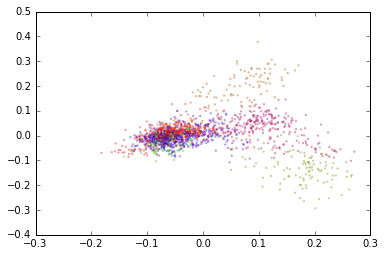

In [32]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
clustering = KMeans(n_clusters=10)
predicted_clusters = clustering.fit_predict(facts_lsa)
plt.scatter(facts_lsa[:,1], facts_lsa[:,2], c=predicted_clusters, cmap='brg', s=5, alpha=.4, lw=0)
plt.show()

## Prediction

In this section I discuss my attempts to predict the outcome of Supreme Court Cases. This was signifigantly more difficult than the clustering problem, and I suspect that more data/different data would be needed to make any additional improvements to this algorithm.

### Techniques
I tried practically every classification technique covered in class (with the exeption of neural networks) on this problem. However in the interest of time and space, I will limit myself to the three most promising. Those were (from most to least effective) Logistic Regression, Multinomial Naive Bayes, and Support Vector Machines. I chose these based on my data, as well as by trial and error. In this case I was using all almost 250 features, several of which were text features that I then vectorized using count data to create thousands of more features. Because of this I was working with extremely large, sparse matricies.  Therefore I needed something that was friendly to sparse data and scaled well to number of features. This ruled out LDA, which doesn't like sparse features. Additionally I was able to rule out Decision Trees, which don't do well with large dimensonal spaces. I did attempt to use LSA as in the clustering example to reduce my dimensionality, and then feed those features to LDA and Support Vector Machine, however in no case did an algorithm using LSA features outperform an algorithm directly working with the sparse features. The three most difficult to predict across my model were Kagan, Kennedy and Thomas. This makes sense because Kennedy is known to be a swing vote, and Thomas famously never speaks during argument. Therefore it is logical that these two would be the most difficult to predict. Finally, Kagan is the most junior justice, so she has the least data available.

#### Logistic Regression 
I started with a basic logicstic regression model. This performed very poorly on my sparse data with no regularization. I then attempted both a ridge and a lasso, which improved performance, but not by a lot. I was still well below the accuracy of both random guessing and assigning everything to 'petitioner wins.' Most of my problems were coming from overfitting, I figure, due to the truly massive number of features I was working with. I then turned to bagging and bootstraping. That together withmy regularization penalties improved my results further. I also used ANOVA to do some feature selection before even passing features into my model. The parameters are set with cross validation. These results were surprisingly good. They exceeded my expectations, with extensive regularization. I had expected the opposite because there wasn't a lot of separation when I used PCA to plot my data, and we learned in class that Logistic Regression struggles where there isn't clear separation. However, this model was the most performant when trained carefully with aggressive regularization parameters.

#### Support Vector Classifiers
These were some of the worst performing algorithms I tried (of the ones that I am covering here. Decision Trees and LDA were so useless I am not even covering them here. I attempted to use Latant Semantic Analysis to find principal components in my text features and feed those to a support vector classifier. I tried a variety of kernel functions, but all of them seemed to over fit except for the linear version. The linear version however was flummoxed by the dense clustering and poor separation my data had in the feature space. My margins were very crowded, and ended up performing almost randomly. I tried some bagging and bootstrapping, but that had not that much effect on my performance which remained, below the performance of my logistic regression.

#### Multinomial Naive Bayes
As I mentioned before, I had tried a Support Vector Classifier, which had not acheived very good results. One thing that I struggled with throughout the process was that my classes were not balanced, and therefore instead of 50% matching 'random guessing', I also had to consider the fact that predicting a victory for the petitioner would yeild a roughly 60% accuracy. Support Vector Classifiers based on Latant Semantic Analysis features were able to do better than 50% but unable to surpass the 60% mark. I therefore turned to Multinomail Naieve Bayes, which is a commonly used algorithm in text analysis. To prevent over fitting I used feature selection based on an chi-squared test for each prospective variable. I also used bagging to reduce overfitting. I tried bootstrapping, but I think the fact that it increased the correlation of my variables, when independence is one of the assumptions of naive bayes, caused it to hurt my modeling. I set my model parameters with cross validation, though because the space of parameters was so large I used random sampling on that space to limit my compute time. This ended up being almost comparable to my logistic regression model, and it may not be easy to distinguish between the two, and I am reluctant to say either is better. However Logistic Regression performed the best on the test set, if only by a little.


### Considerations
When you have more than 10,000 features, you have to be really careful about overfitting, so I used an agressive bagging and bootstrapping approach to minimize this in my Naive Bayes model. Additionally, I witheld a testing set to ensure that I wasn't overfitting to my training set. To separate out my training set I pulled out the last year and a half of decisions. This came out to about 75 decisions for each justice, give or take. I did this rather than randomly selecting a subset because I want to know if training on the past can allow you to predict the future, and this way I am simulating that.

### Results
I found that regardless of the algorithm used, creating a separate model for each justice out performed simply predicting the outcome of the case on validation data. Below I generate the test and train datasets for each justice. Unfortunately, I was unable to do an analysis of what attorneys could do to improve their advocacy as my models that were accurate were improved by removing any data about what the attorneys said in the arguments. I guess that my result is that attorneys don't effect the outcome of the case as much as they think they do. Below I train the models on my training data and print a set of performance metrics about each model

kennedy
             precision    recall  f1-score   support

         -1       0.75      0.87      0.81       547
          1       0.56      0.35      0.43       250

avg / total       0.69      0.71      0.69       797

Accuracy: 0.710163111669
Normalized Accuracy: 0.110163111669
Matthews: 0.263486389467


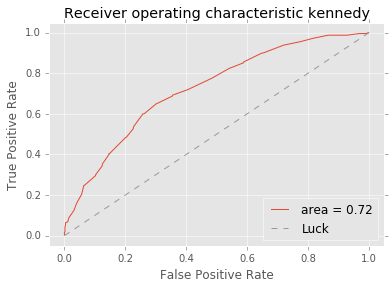

             precision    recall  f1-score   support

         -1       0.75      0.86      0.80        49
          1       0.42      0.26      0.32        19

avg / total       0.66      0.69      0.67        68

Accuracy: 0.691176470588
Normalized Accuracy: 0.0911764705882
Matthews: 0.141598465081


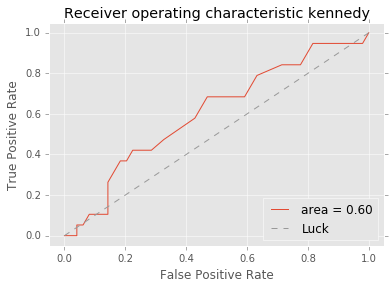

---------------------------------
thomas
             precision    recall  f1-score   support

         -1       0.71      0.86      0.78       497
          1       0.64      0.43      0.52       300

avg / total       0.69      0.70      0.68       797

Accuracy: 0.696361355082
Normalized Accuracy: 0.0963613550816
Matthews: 0.321289441224


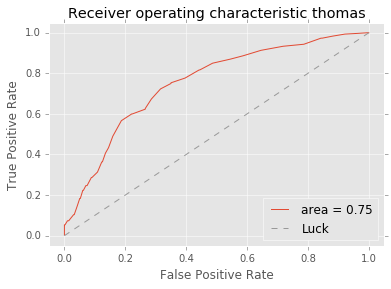

             precision    recall  f1-score   support

         -1       0.68      0.77      0.72        39
          1       0.62      0.52      0.57        29

avg / total       0.66      0.66      0.66        68

Accuracy: 0.661764705882
Normalized Accuracy: 0.0617647058824
Matthews: 0.296470679422


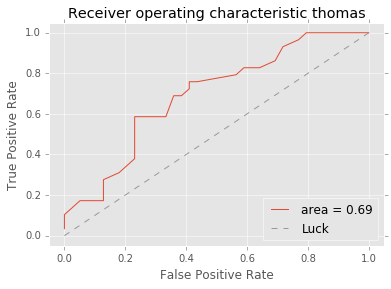

---------------------------------
ginsburg
             precision    recall  f1-score   support

         -1       0.79      0.80      0.80       488
          1       0.68      0.66      0.67       309

avg / total       0.75      0.75      0.75       797

Accuracy: 0.749058971142
Normalized Accuracy: 0.149058971142
Matthews: 0.469041577922


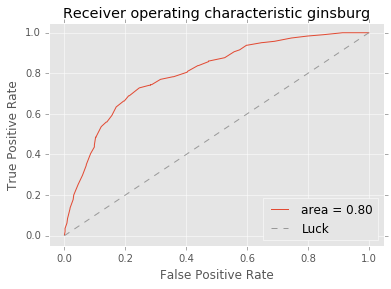

             precision    recall  f1-score   support

         -1       0.79      0.66      0.72        47
          1       0.45      0.62      0.52        21

avg / total       0.69      0.65      0.66        68

Accuracy: 0.647058823529
Normalized Accuracy: 0.0470588235294
Matthews: 0.260281208807


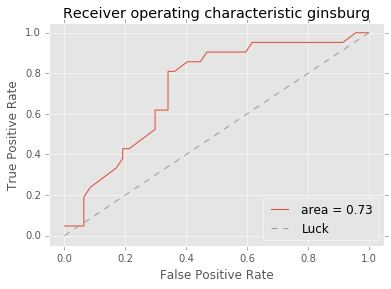

---------------------------------
breyer
             precision    recall  f1-score   support

         -1       0.78      0.85      0.81       508
          1       0.68      0.58      0.63       287

avg / total       0.75      0.75      0.75       795

Accuracy: 0.750943396226
Normalized Accuracy: 0.150943396226
Matthews: 0.444987018806


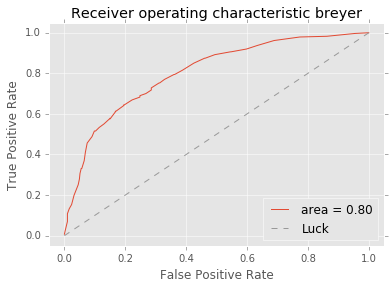

             precision    recall  f1-score   support

         -1       0.88      0.67      0.76        52
          1       0.39      0.69      0.50        16

avg / total       0.76      0.68      0.70        68

Accuracy: 0.676470588235
Normalized Accuracy: 0.0764705882353
Matthews: 0.310778223812


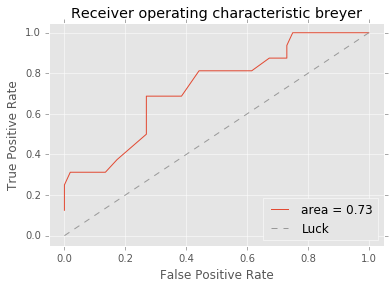

---------------------------------
roberts
             precision    recall  f1-score   support

         -1       0.75      0.89      0.81       427
          1       0.66      0.42      0.52       222

avg / total       0.72      0.73      0.71       649

Accuracy: 0.727272727273
Normalized Accuracy: 0.127272727273
Matthews: 0.353297545233


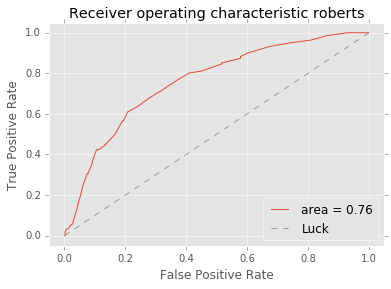

             precision    recall  f1-score   support

         -1       0.87      0.62      0.73        53
          1       0.33      0.67      0.44        15

avg / total       0.75      0.63      0.66        68

Accuracy: 0.632352941176
Normalized Accuracy: 0.0323529411765
Matthews: 0.241597171804


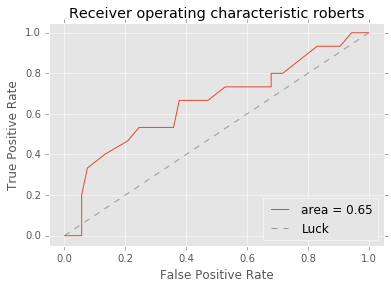

---------------------------------
alito
             precision    recall  f1-score   support

         -1       0.73      0.83      0.78       382
          1       0.67      0.53      0.59       247

avg / total       0.71      0.71      0.71       629

Accuracy: 0.712241653418
Normalized Accuracy: 0.112241653418
Matthews: 0.380262142094


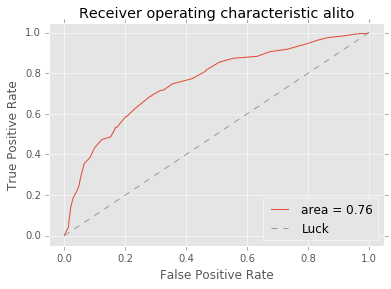

             precision    recall  f1-score   support

         -1       0.90      0.81      0.85        47
          1       0.64      0.80      0.71        20

avg / total       0.83      0.81      0.81        67

Accuracy: 0.805970149254
Normalized Accuracy: 0.205970149254
Matthews: 0.575754647734


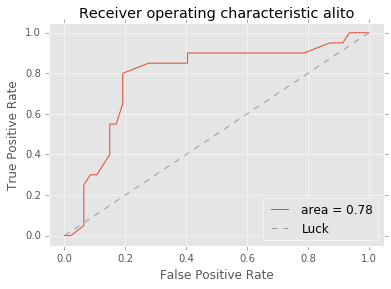

---------------------------------
sotomayor
             precision    recall  f1-score   support

         -1       0.75      0.83      0.79       220
          1       0.68      0.57      0.62       141

avg / total       0.72      0.73      0.72       361

Accuracy: 0.725761772853
Normalized Accuracy: 0.125761772853
Matthews: 0.410475592081


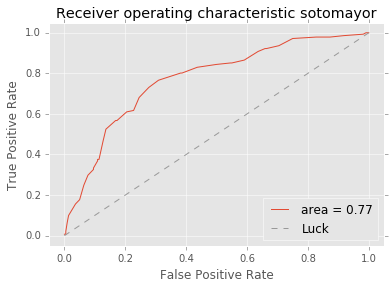

             precision    recall  f1-score   support

         -1       0.86      0.73      0.79        51
          1       0.44      0.65      0.52        17

avg / total       0.76      0.71      0.72        68

Accuracy: 0.705882352941
Normalized Accuracy: 0.105882352941
Matthews: 0.334571344404


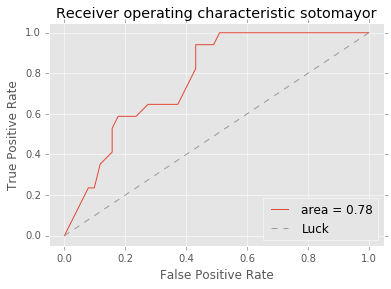

---------------------------------
kagan
             precision    recall  f1-score   support

         -1       0.76      0.87      0.81       165
          1       0.71      0.56      0.63        99

avg / total       0.75      0.75      0.74       264

Accuracy: 0.75
Normalized Accuracy: 0.15
Matthews: 0.449712014915


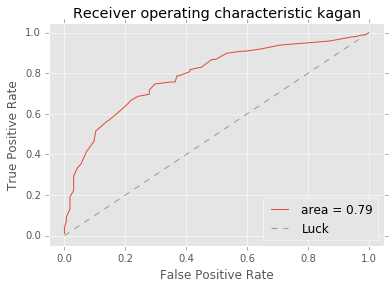

             precision    recall  f1-score   support

         -1       0.76      0.77      0.76        48
          1       0.42      0.40      0.41        20

avg / total       0.66      0.66      0.66        68

Accuracy: 0.661764705882
Normalized Accuracy: 0.0617647058824
Matthews: 0.173473599915


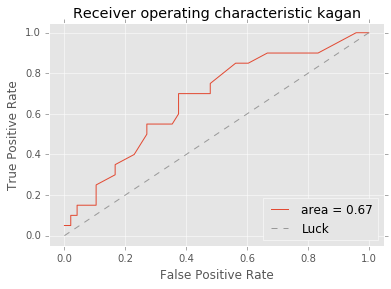

In [930]:
import numpy as np
% aimport scotus.learn.transformers
% aimport scotus.learn.predict
% aimport scotus.learn.data
% autoreload
j_names = ['kennedy', 'thomas', 'ginsburg', 'breyer', 'roberts', 'alito', 'sotomayor', 'kagan']
j_data = {name: scotus.learn.data.prep_justice(name, data, 
                                               cutoff_year=2013,
                                               cutin_year=2003) for name in j_names}
models = {}
top = True
for name in j_names:
    if top:
        top = False
    else:
        print '---------------------------------'
    print name
    X, y = j_data[name]['train']
    Xt, yt = j_data[name]['test']
    params = scotus.learn.predict.lr_params(turn_text, j_names)
    model = scotus.learn.predict.lr_model(['questions', 'count', 'facts', 'length', 
                                           'speaker', 'advocate'],
                                            turn_text, count, length, j_names)
    model.fit(X,y)
    scotus.learn.predict.test_roc(model, X, y, name=name)
    models[name] = model
    scotus.learn.predict.test_roc(model, Xt, yt, name=name)
    

## Conclusion
This project was not as successful as I would have liked. I think it is likely that there is not enough data or this is not the right data to try to make the predictions I would like to make. I would propose to my customer that we possibly scrape the parties' briefs, which are available online, or possibly work with a legal expert to figure out the sorts of features or data we would need to feed the model. However, I was able to beat guessing the petitioner every time. I also might think a deep neural network might be a good technique to try. I may try to make some of those improvements this summer. I look forward to seeing how my predictions for the rest of the term compare with reality as it unfolds. It would be useful also to sit with a lawyer and see what they think of the logistic regression's probabilities.  This would let me know if the probabilities coming from my model are meaningful or if I am on the wrong track.

## Epilogue: Predictions for Cases Remaining in the October 2015 Term
I trained my Logistic Regression model on all the data up through the 2014 term and I have used it below to make predictions about cases this term. I made the predictions on April 17, and I will update this as the term progresses to see how I do.

In [948]:
from sklearn.externals import joblib
% aimport scotus.learn.data
% autoreload
j_names = ['kennedy', 'thomas', 'ginsburg', 'breyer', 'roberts', 'alito', 'sotomayor', 'kagan']
generate = True
save = False
models = {}
for name in j_names:
    if generate:
        X, y = scotus.learn.data.get_data(name, data, cutin_year=2003, cutoff_year=2014)
        params = scotus.learn.predict.lr_params(turn_text, j_names)
        model = scotus.learn.predict.lr_model(['questions', 'count', 'facts', 'length', 
                                               'speaker', 'advocate'],
                                                turn_text, count, length, j_names)
        model.fit(X,y)
        models[name]=model
        if save:
            joblib.dump('models/'+name+'_model.pkl')
    else:        
        models[name] = joblib.load('models/'+name+'_model.pkl')

In [992]:
current_term = data[(data['term']>=2015)|(data['date_decided']==0)]
predictions = []
for name in j_names:
    predictions.append(np.atleast_2d(models[name].predict_proba(current_term)[:, 0]).T)
predictions = np.hstack(predictions)

Wittman v. Personhuballah
In 2012, the Virginia State Legislature adopted a redistricting plan that altered the composition of the Third Congressional District, which was already majority African-American, and increased the percentage of African-American voters in the district. Pursuant to Section 5 of the Voting Rights Act, the plan was submitted to the Department of Justice for preclearance, which was granted. On October 2, 2013, plaintiffs sued the defendants in their official capacities and argued that Virginia’s Third Congressional District was racially gerrymandered in violation of the Equal Protection Clause of the Fourteenth Amendment. The district court ruled that the districting plan was unconstitutional because its use of race as a factor was not sufficiently narrowly tailored to serve a compelling government interest.

The defendants appealed to the U.S. Supreme Court, which remanded the case for reconsideration in light of its decision in Alabama Legislative Black Caucus v

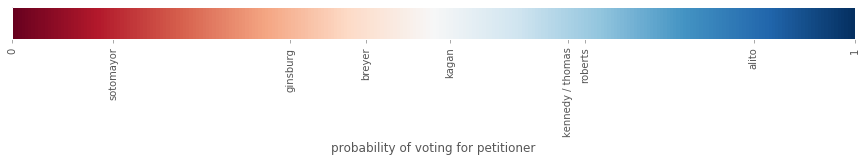

Predicted Outcome: 5-3 Win for Petitioner


Pending



--------------------------------------------------------
Ocasio v. United States
Samuel Ocasio was a police officer of the Baltimore Police Department who was indicted in connection with a kickback scheme involving payments to police officers in exchange for referrals to Majestic Auto Repair Shop (Majestic). The indictment charged Ocasio with conspiring to violate the Hobbes Act by agreeing to unlawfully obtain money or property under color of right from Majestic. The jury convicted Ocasio, and he appealed by arguing that he cannot be guilty of conspiring to commit extortion with the owners of Majestic because they were also the victims of the conspiracy, and the victim of a Hobbes Act conspiracy must be a person outside of the alleged conspiracy. The U.S. Court of Appeals for the Fourth Circuit affirmed Ocasio’s conviction.


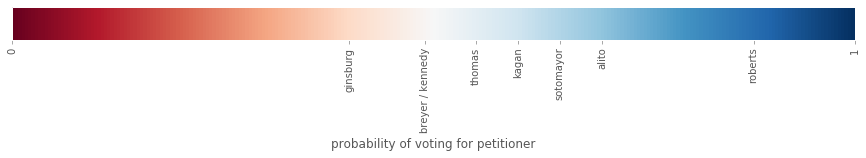

Predicted Outcome: 6-2 Win for Petitioner


Pending



--------------------------------------------------------
Hawkins v. Community Bank of Raymore
Valerie Hawkins and Janice Patterson’s husbands are the two members of PHC Development, LLC (PHC). Between 2005 and 2008, Community Bank of Raymore (Community) made four loans totaling more than $2,000,000 to PHC for the development of a residential subdivision. The Hawkins and Pattersons each executed personal guaranties to secure the loans. In April 2012, PHC failed to make the payments due under the loan agreements, and Community declared the loans to be in default, accelerated the loans, and demanded payment.

Hawkins and Patterson sued Community seeking damages and an order declaring their guaranties void and unenforceable. They argued that they had only been required to execute their guaranties because they were married to their respective husbands, which constituted discrimination based on their marital status in violation of the Eq

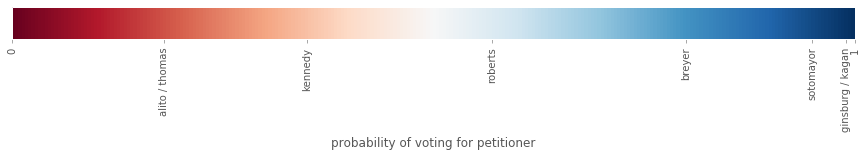

Predicted Outcome: 5-3 Win for Petitioner


Actual Outcome: Equally Divided Court



--------------------------------------------------------
OBB Personenverkehr AG v. Sachs
OBB Personenverkehr AG (OBB) is owned by OBB Holding Group, a joint-stock company created by the Republic of Austria to operate rail service within Austria. OBB is a member of the Eurail Group, an association organized under Luxembourg law to provide rail pass to non-European residents.

In March 2007, Carol Sachs purchased a four-day Eurail Pass from the Rail Pass Experts (RPE) website for travel in Austria and the Czech Republic. RPE is located in Massachusetts, and the pass Sachs purchased listed a series of disclaimers, including that the “issuing office is merely an intermediary of the carriers in Europe and assumes no liability resulting from the transport.” In April 2007, Sachs used her Eurail Pass in Innsbruck, Austria. While boarding the train, Sachs fell between the tracks, and her legs were crushed by th

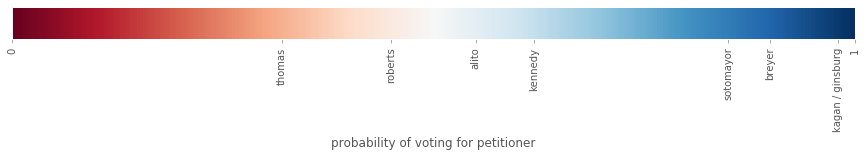

Predicted Outcome: 6-2 Win for Petitioner


Actual Outcome: 8-0 Win for Petitioner
Petitioner: kennedy, thomas, ginsburg, breyer, roberts, alito, sotomayor, kagan
Respondent: 



--------------------------------------------------------
Tyson Foods, Inc. v. Bouaphakeo
Peg Bouaphakeo and the rest of the plaintiff class are current and former employees of Tyson Foods, Inc. (Tyson) at the company’s meat-processing facility in Storm Lake, Iowa. The employees worked on a “gang-time” system, which means they were paid only for time they were at their working stations and the production line was moving. The employees sued Tyson and argued that the company violated the Fair Labor Standards Act of 1938 and the Iowa Wage Payment Collection Law by not paying appropriate compensation for the time spent putting on and taking off protective clothing at the beginning and end of the work day and lunch break. The district court certified the class, and the jury returned a verdict in favor of the plainti

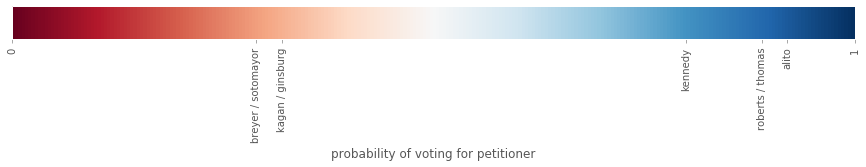

Predicted Outcome: Equally Divided Court


Actual Outcome: 6-2 Win for Petitioner
Petitioner: kennedy, ginsburg, breyer, roberts, sotomayor, kagan
Respondent: thomas, alito



--------------------------------------------------------
Welch v. United States
Police entered Gregory Welch’s apartment because they had reason to believe that a robbery suspect was on the premises. After obtaining Welch’s consent to search the apartment, the police located a gun and ammunition that Welch later identified as his own. Welch was subsequently arrested and charged with be in a felon in possession of a firearm, and he pleaded guilty. Because Welch had three prior felony convictions, the district court determined that the Armed Career Criminal Act (ACCA) required that he be sentenced to a minimum of 15 years in prison. Welch appealed his sentence and argued that one of his felonies, a conviction for “strong arm” robbery in Florida state court in 1996, did not qualify as a predicate offense for the pur

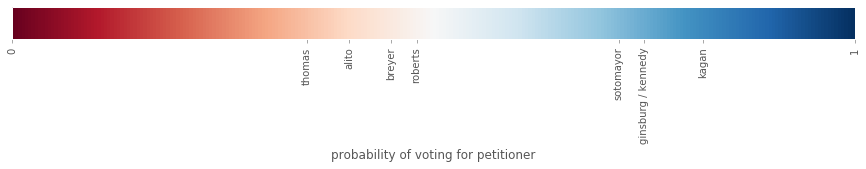

Predicted Outcome: Equally Divided Court


Pending



--------------------------------------------------------
United States Army Corps of Engineers v. Hawkes Co., Inc.
Hawkes Co., Inc. (Hawkes) was interested in purchasing a piece of land in northern Minnesota to mine high-quality peat. Hawkes applied to the Army Corps of Engineers (Corps) and the Minnesota Department of Natural Resources for a permit to begin extracting peat from the land once they purchased the property in October 2010. The Corps informed Hawkes that the permit process would be very costly and would take a long time and so urged Hawkes not to purchase the property. The Corps then submitted an Approved Jurisdictional Determination to derail Hawkes’ plan to purchase and mine the property by arguing that the land was a wetland connecting to “waters of the United States,” which are protected under the Clean Water Act. Hawkes challenged the jurisdictional determination and filed an action for immediate judicial review. T

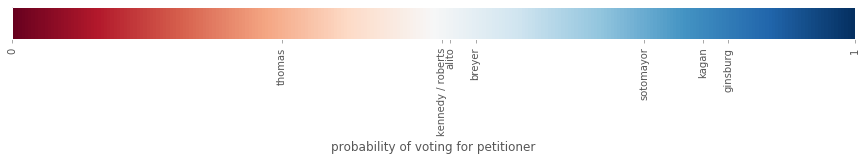

Predicted Outcome: 7-1 Win for Petitioner


Pending



--------------------------------------------------------
Ross v. Blake
On June 21, 2007, Lieutenants Michael Ross and James Madigan were escorting Shaidon Blake from his cell when Madigan shoved Blake several times. The incident escalated to Madigan punching Blake in the face several times with a key ring wrapped around his fingers while Ross held him. Blake was then taken to the medical unit and later diagnosed with nerve damage. Blake reported the incident to senior corrections officers, and the Internal Investigative Unit of the Maryland Department of Public Safety and Correctional Services conducted an investigation and issued a formal report. The formal report determined that Madigan had used excessive force against Blake and that Blake was not at fault in any way. Blake subsequently sued Ross and Madigan in addition to two supervisors and three government entities under 42 U.S.C. § 1983 and argued that they violated his const

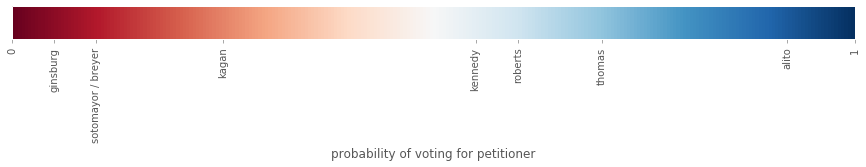

Predicted Outcome: Equally Divided Court


Pending



--------------------------------------------------------
Sheriff v. Gillie
In 1977, Congress enacted the Federal Debt Collection Practices Act (FDCPA) in an effort to combat abusive debt collection practices, which were particularly problematic with third party or independent debt collectors, who are unlikely to have contact with the consumer and therefore have little incentive to act fairly. One of the issues that the FDCPA addressed was independent debt collectors representing themselves as government officials. Therefore, the FDCPA targeted these “debt collectors” while exempting government officials from that definition. The statutory language of the exemption was specific to “any officer or employee of ... any State to the extent that collecting or attempting to collect any debt is in the performance of his official duties.”

The Ohio Revised Code contains a provision that unpaid debts owed to a state entity get “certified” to 

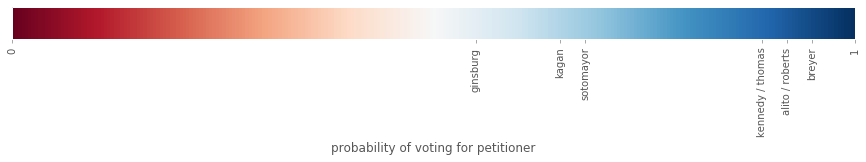

Predicted Outcome: 8-0 Win for Petitioner


Pending



--------------------------------------------------------
CRST Van Expedited v. EEOC
The Equal Employment Opportunity Commission (EEOC) filed a sexual harassment suit on behalf of approximately 270 female employees against CRST Van Expedited (CRST). Two years after filing the suit, the EEOC failed to identify the 270 women, and the district court ordered the EEOC to amend its list of 270 women to include only the women who wished to continue with the suit and to ensure that those women be available for deposition. The EEOC complied with the first court order and failed to fulfill the second before the deadline. CRST had filed seven motions to dismiss, and the district granted (or granted in part) six of the motions. CRST subsequently filed a bill of costs against the EEOC for $4,560,285.11, and the district court granted the fee award.The EEOC appealed, and the U.S. Court of Appeals for the Eighth Circuit reversed the fee award. The

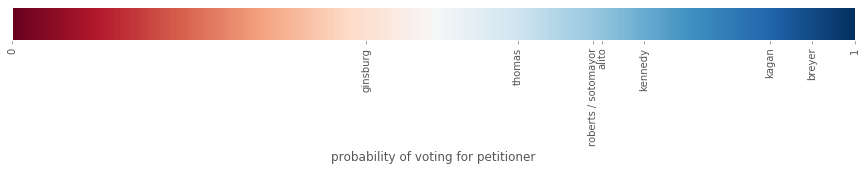

Predicted Outcome: 7-1 Win for Petitioner


Pending



--------------------------------------------------------
Puerto Rico v. Franklin California Tax-Free Trust
Unlike states, the Commonwealth of Puerto Rico may not authorize its municipalities, including utilities, to declare bankruptcy and seek relief under Chapter 9 of the U.S. Bankruptcy Code. In June 2014, Puerto Rico enacted the Puerto Rico Public Corporation Debt Enforcement and Recovery Act (Recovery Act), which expressly provided different protections for creditors than Chapter 9 of the U.S. Bankruptcy Code.

The plaintiffs in this case are a group of investors who collectively hold nearly two billion dollars in bonds issued by one of Puerto Rico’s public utilities, the Puerto Rico Electric Power Authority (PREPA), which could potentially file for bankruptcy under the Recovery Act. The plaintiffs sued Puerto Rico in district court and argued that Chapter 9 of the U.S. Bankruptcy Code, which prohibits state municipal debt rest

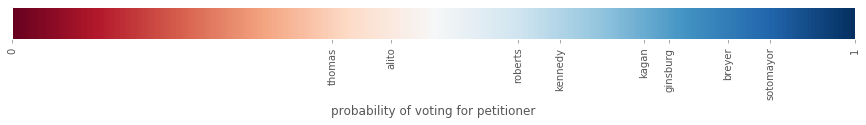

Predicted Outcome: 6-2 Win for Petitioner


Pending



--------------------------------------------------------
Betterman v. Montana
Brandon Thomas Betterman failed to appear in court on December 8, 2011, on charges of partner or family member assault, and a warrant was issued for his arrest. On February 9, 2012, Betterman turned himself in and stated that he knew he was supposed to appear in court but claimed he had neither money nor transportation to get to the courthouse that day. He was convicted on March 15, 2012, and sentenced to five years. On April 19, 2012, he pled guilty to the charges of jumping bail. His sentence hearing did not occur until January 17, 2013, when he filed a motion to dismiss on the grounds that he was denied a speedy and fair trial due to the amount of time that had lapsed between his guilty plea and sentencing hearing. On April 29, 2013, his motion was denied, and on June 27, 2013, Betterman was sentenced to seven years for his bail-jumping charge. The Sup

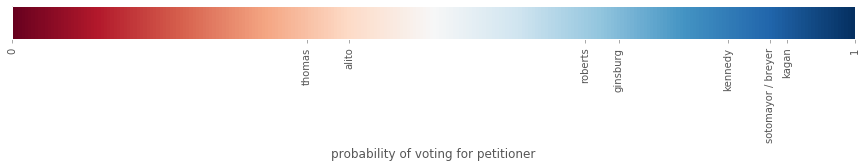

Predicted Outcome: 6-2 Win for Petitioner


Pending



--------------------------------------------------------
Simmons v. Himmelreich
Walter Himmelreich is a federal prisoner at the Federal Correctional Institution in Danbury, Connecticut. In 2008, he was attacked by another prisoner. Himmelreich filed a complaint against multiple defendants alleging many causes of action, including a claim that his First Amendment rights were violated when he was placed in administrative detention after filing a claim under the Federal Torts Claims Act (FTCA) and a claim that his Eighth Amendment rights were violated when the prison officials failed to protect him from being assaulted by another inmate. The district court dismissed his case for failure to state a claim. On appeal, the U.S. Court of Appeals for the Sixth Circuit vacated the decision and remanded the case for reconsideration of the First and Eighth Amendment claims.

On remand, the district court granted summary judgment for the defend

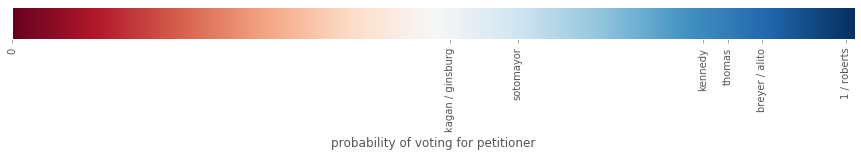

Predicted Outcome: 8-0 Win for Petitioner


Pending



--------------------------------------------------------
Whole Woman’s Health v. Hellerstedt
In 2013, the Texas Legislature passed House Bill 2 (H.B. 2), which contained several provisions related to abortions. One such provision required that any physician performing an abortion have admitting privileges at a hospital within 30 miles of where the abortion was performed, and another provision required that all abortion clinics comply with standards for ambulatory surgical centers. The petitioners are a group of abortion providers who sued the State of Texas seeking to invalidate those provisions in H.B. 2 as they relate to facilities in McAllen and El Paso. The petitioners argued that H.B. 2 denied equal protection, unlawfully delegated lawmaking authority, and constituted arbitrary and unreasonable state action. The district court dismissed the equal protection, unlawful delegation, and arbitrary and unreasonable state action clai

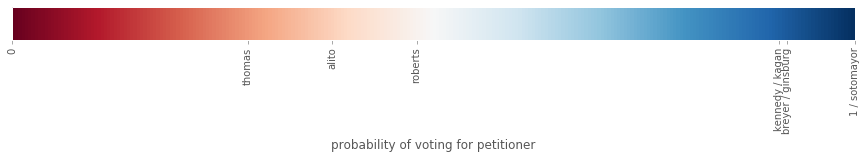

Predicted Outcome: 5-3 Win for Petitioner


Pending



--------------------------------------------------------
Zubik v. Burwell
In 2010, Congress passed the Affordable Care Act (ACA), which requires group health plans and health insurance issuers offering health plans to provide preventative care and screenings for women pursuant to the guidelines established by the Department of Health and Human Services (HHS). These guidelines include “approved contraceptive methods, sterilization procedures, and patient education and counseling for all women with reproductive capacity.” The regulations include an exemption from contraceptive coverage for the group health plan of a religious employer. The exemption does not mean that such services are not covered, but that they are not covered through a cost-sharing mechanism.

The petitioners are religious organizations that argue that the contraceptive coverage mandate of the ACA violates the Religious Freedom Restoration Act (RFRA), which Congres

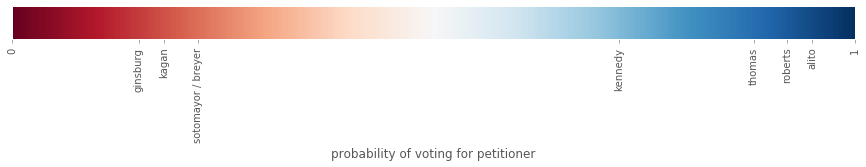

Predicted Outcome: Equally Divided Court


Pending



--------------------------------------------------------
Husky Electronics v. Ritz
Husky International Electronics, Inc. (Husky) sold and delivered electronic equipment to Chrysalis Manufacturing Corp. (Chrysalis), headed by Daniel Ritz. Chrysalis owed Husky $163,999.38 in purchases between 2003 and 2007. In 2007, Ritz started transferring funds from Chrysalis to various other ventures in which he owned stock. In 2009 Husky sued Ritz for payment of his outstanding debt, and Ritz then filed for Chapter 7 bankruptcy. In 2011, Husky filed a complaint against the discharge of Ritz’s debt and argued that Ritz had fraudulently moved funds from Chrysalis to other accounts in order to file for bankruptcy. The bankruptcy court found that Ritz had not fraudulently filed for bankruptcy and that it could not “pierce the veil” to go after Ritz’s personal finances for the debt Chrysalis owed.

Husky appealed to the district court, which affirmed 

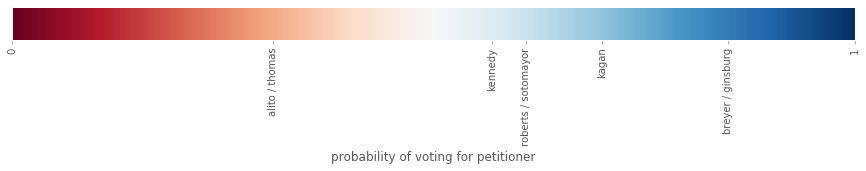

Predicted Outcome: 6-2 Win for Petitioner


Pending



--------------------------------------------------------
Nichols v. United States
In 2003, Lester Nichols was charged with intent to engage in sex with a minor. In 2006, the Sexual Offender Registration and Notification Act (SORNA) was passed, and the Attorney General issued a rule in 2007 that SORNA applied retroactively to convicted sex offenders. Under this rule, Nichols was required to register with SORNA and update his residency. In 2012, Nichols flew from Kansas to the Philippines without updating his location pursuant to SORNA. Authorities in the Philippines took Nichols into custody and returned him to the United States where he was charged with noncompliance with SORNA regulations regarding updating his residency. Nichols filed a motion to dismiss and argued that the Philippines are outside U.S. jurisdiction, so he was not required to update his location. The trial court dismissed his motion, and Nichols plead guilty. He t

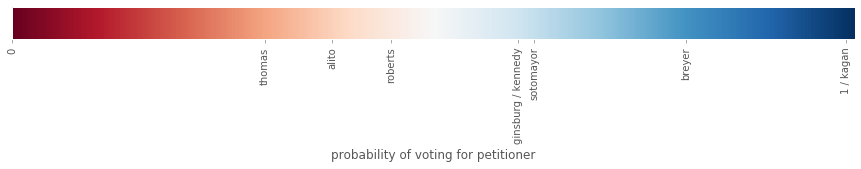

Predicted Outcome: 5-3 Win for Petitioner


Actual Outcome: 8-0 Win for Petitioner
Petitioner: kennedy, thomas, ginsburg, breyer, roberts, alito, sotomayor, kagan
Respondent: 



--------------------------------------------------------
Voisine v. United States
In 2003 and 2005, Stephen Voisine was convicted of assaulting a woman (with whom he was in a domestic relationship) under a Maine state statute that establishes that a person is guilty of assault if that person “knowingly, intentionally, or recklessly causes bodily injury or offensive physical contact to another person.” A violation of that statute is misdemeanor domestic violence assault if the victim is a family or household member. In 2009, Voisine was arrested on the federal misdemeanor charge of killing a bald eagle. During the course of the investigation, police recovered a rifle from Voisine and, because of his earlier misdemeanor assault convictions, arrested and charged Voisine with violating a federal statute that makes

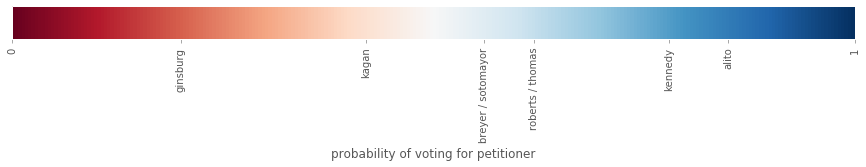

Predicted Outcome: 6-2 Win for Petitioner


Pending



--------------------------------------------------------
Franchise Tax Board of California v. Hyatt
Throughout the 1990s, inventor Gilbert P. Hyatt was involved in litigation with the Franchise Tax Board of California (FTB) based on the FTB’s audits of his 1991 and 1992 tax returns. The FTB claimed that Hyatt had falsified his tax forms by manufacturing a move to Nevada that did not occur until later and therefore failing to file state taxes for time that he was actually living in California. Hyatt protested that the FTB acted in bad faith and eventually sued the FTB in Nevada alleging negligence along with several intentional torts and seeking damages. Before the case went to trial, the FTB argued that it should be immune from the lawsuit based on California law that granted it sovereign immunity. The case eventually went before the U.S. Supreme Court, which held that Nevada courts were not bound to grant the FTB full immunity.

A

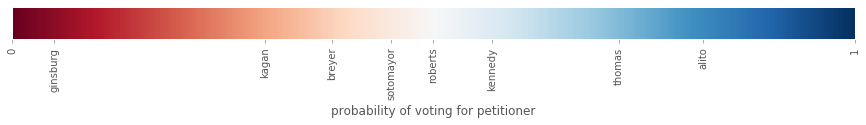

Predicted Outcome: Equally Divided Court


Pending



--------------------------------------------------------
Halo Electronics v. Pulse Electronics Inc.
Halo Electronics, Inc. (Halo) and Pulse Electronics, Inc. (Pulse) are both suppliers of electronic components. Halo owns three patents regarding surface mount electronic packages; Pulse designs and sells surface mount electronic packages and does its manufacturing in Asia. In 2002, Halo unsuccessfully attempted to license their patents to Pulse. In 2007, Halo sued Pulse for patent infringement. The district court held that Pulse infringed on Halo’s patents with products shipped into the United States, had induced others to infringe on products delivered outside of the U.S. but ultimately imported into the U.S. as finished products, and found that it was highly probable that Pulse’s infringement was willful. The court later found that Pulse’s infringement was not willful. The U.S. Court of Appeals for the Federal Circuit affirmed and h

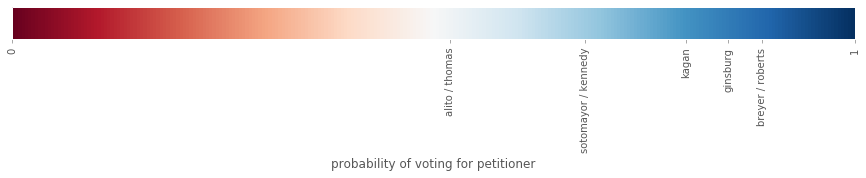

Predicted Outcome: 8-0 Win for Petitioner


Pending



--------------------------------------------------------
Hughes v. Talen Energy Marketing, LLC
The Federal Power Act (FPA) was passed in 1935 to regulate interstate electricity sales. The FPA vested the Federal Energy Regulatory Commission (FERC) with authority over the transmission of electrical energy in interstate commerce and the wholesale of electric energy in interstate commerce. To this end, FERC has created regional transmission organizations, such as PJM Interconnection, LLC, (PJM) which regulates a large regional market that includes Maryland and the District of Columbia. Maryland became concerned that FERC actions were failing to adequately incentivize the construction of new plants, so the Maryland Public Service Commission began soliciting proposals for the construction of a new plant and instituted a Generation Order to regulate how the company that won the bid would interact with the rest of the energy market. Commer

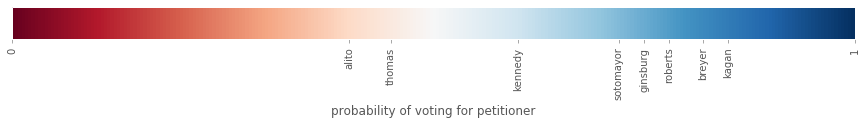

Predicted Outcome: 6-2 Win for Petitioner


Pending



--------------------------------------------------------
Puerto Rico v. Sanchez Valle
In 2008, Luis M. Sanchez Valle was charged in federal for illegally trafficking in weapons and ammunition in interstate commerce and, on substantially the same facts, was charged with several violations of the Puerto Rico Weapons Act. After Sanchez Valle was convicted in federal court, he filed a motion to dismiss the claims under Puerto Rican law and argued that the constitutional protection against double jeopardy meant that he could not be prosecuted in Puerto Rico for the same offenses for which the federal court had already convicted him. The prosecution argued that, pursuant to the precedent the Supreme Court of Puerto Rico established in Puerto Rico v. Castro García, the United States and the Commonwealth of Puerto Rico derive their authority from different sources and therefore can punish substantially the same offenses without implicating

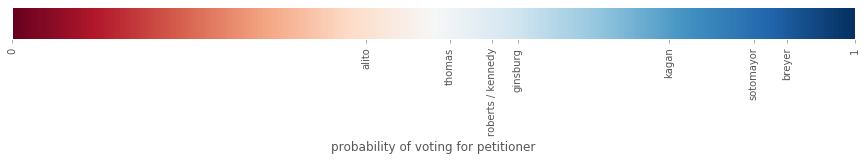

Predicted Outcome: 7-1 Win for Petitioner


Pending



--------------------------------------------------------
Williams v. Pennsylvania
Terrance Williams was convicted and sentenced to death for the robbery and murder of Amos Norwood. The Supreme Court affirmed Williams’ conviction and sentence, and he filed three petitions under the Post-Conviction Relief Act, all of which were denied and the denials affirmed by the Pennsylvania Supreme Court. Williams also petitioned for federal habeas relief, which was denied. On his fourth petition for relief under the Post-Conviction Relief Act, the state court determined that Williams had sufficiently demonstrated that there was governmental interference in his trial and granted the relief. The Pennsylvania Supreme Court reversed the lower court’s decision and lifted the stay of execution.

The Chief Justice of the Pennsylvania Supreme Court at that point was Ronald Castille, who had been the District Attorney for Philadelphia throughout William

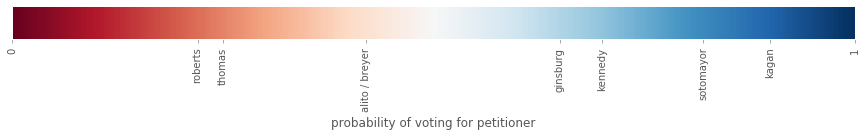

Predicted Outcome: Equally Divided Court


Pending



--------------------------------------------------------
Heffernan v. City of Paterson
Jeffrey Heffernan was a police officer for the City of Paterson, New Jersey. A fellow police officer observed Heffernan picking up a campaign sign for the mayoral candidate running against the incumbent. When a supervisor confronted him, Heffernan claimed that he was not politically involved, could not vote in the City of Paterson, and was picking up the sign on behalf of his mother. Heffernan was demoted to a walking post because his actions were considered to be “overt involvement in political activities.” Heffernan sued the City of Paterson and claimed that the City had violated his First Amendment rights to freedom of speech association. However, the City filed a motion for summary judgment on Heffernan’s free association claim. The district court granted the City’s motion for summary judgment because there was no evidence Heffernan associated

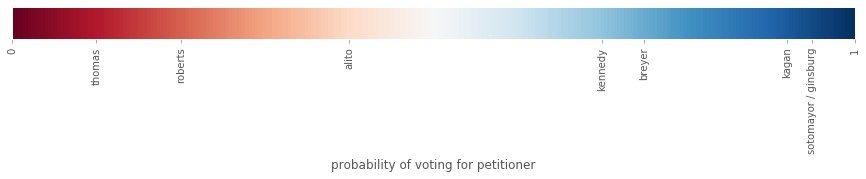

Predicted Outcome: 5-3 Win for Petitioner


Pending



--------------------------------------------------------
Bank Markazi v. Peterson
Deborah Peterson and a group of other plaintiffs were seeking to obtain judgments for injury or wrongful death during acts of terrorism by Iran. The Iran Central Bank (Bank Markazi) owned nearly $2 billion worth of bonds that were held in an account in New York City. Based on the Uniform Commercial Code, these assets were not considered assets of Bank Markazi, and therefore could not be attached by the plaintiffs and were immune from attachment under the Foreign Sovereign Immunities Act.

While this case was pending, Congress passed the Iran Threat Reduction and Syria Human Rights Act of 2012, Section 8772 of which stated, “[T]he financial assets that are identified in and the subject of proceedings in the United States District for the Southern District of New York in Peterson et al. v. Islamic Republic of Iran et al., shall be subject to execution…i

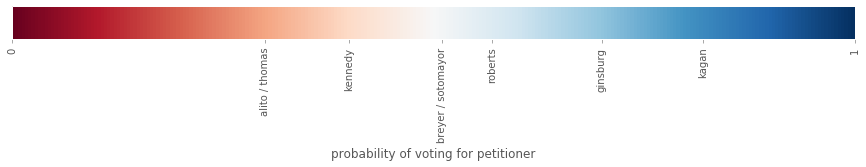

Predicted Outcome: 5-3 Win for Petitioner


Pending



--------------------------------------------------------
Sturgeon v. Frost
John Sturgeon regularly hunted on the Yukon-Charley River National Preserve (Yukon-Charley), which is part of the National Park Service (NPS), in Alaska. Sturgeon used a hovercraft to hunt. During one of his hunting trips, he was approached by three NPS enforcement employees and told that NPS regulations prohibited the operation of hovercrafts within all national parks, and therefore he was prohibited from using his hovercraft within the Yukon-Charley boundaries. Sturgeon insisted that the NPS did not have jurisdiction in the area because it was a state-owned river and subsequently sued Bert Frost, the director of the NPS for Alaska. Sturgeon claimed the NPS violated Alaska National Interest Lands Conservation Act of 1980 (ANILCA) as applied to his use of hovercrafts on state-owned lands and waters because ANILCA limited the applicability of NPS regulations 

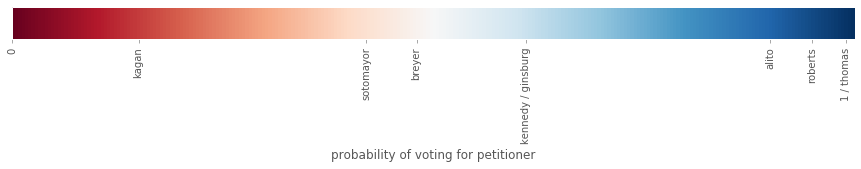

Predicted Outcome: 5-3 Win for Petitioner


Actual Outcome: 8-0 Win for Petitioner
Petitioner: kennedy, thomas, ginsburg, breyer, roberts, alito, sotomayor, kagan
Respondent: 



--------------------------------------------------------
Nebraska v. Parker
Omaha Tribal members attempted to enforce liquor licenses and taxes on local venders and clubs selling alcoholic beverages in Pender, Nebraska. The plaintiffs, the owners of clubs and venues that sold alcoholic beverages in Pender, Nebraska, joined by the state of Nebraska, sued for injunctive relief and argued that they are not located on federally-recognized Indian reservation land and therefore were not under the jurisdiction of the Omaha Tribe. The plaintiffs and defendants cross-filed for summary judgment, and the trial court found in favor of the defendants. The trial court held that Pender, Nebraska, was under the jurisdiction of tribal law because the U.S. Senate’s passage of an 1882 Act that allowed the Omaha tribe to sell all

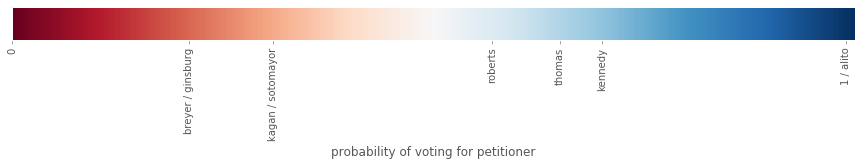

Predicted Outcome: Equally Divided Court


Actual Outcome: 8-0 Win for Petitioner
Petitioner: kennedy, thomas, ginsburg, breyer, roberts, alito, sotomayor, kagan
Respondent: 



--------------------------------------------------------
Americold Realty Trust v. Conagra Foods, Inc., et al.
The plaintiffs, food distributors including Conagra Foods Inc. and Kraft Foodservice, sued Americold Logistics LLC and Americold Realty Trust (Americold) in state court for a breach of contract stemming from a dispute regarding liability for a warehouse fire. Americold sought to remove the case to federal court based on diversity jurisdiction because of the diversity of the trust’s board. No party challenged the propriety of the removal, and the district court addressed the case solely on its merits. Both parties moved for summary judgment, and the district court found in favor of the defendant.

On appeal, the U.S. Court of Appeals of the Tenth Circuit raised the issue of potentially improper removal 

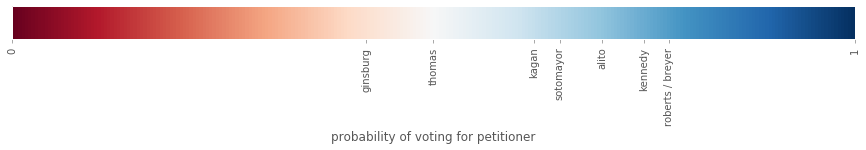

Predicted Outcome: 7-1 Win for Petitioner


Actual Outcome: 8-0 Win for Petitioner
Petitioner: kennedy, thomas, ginsburg, breyer, roberts, alito, sotomayor, kagan
Respondent: 



--------------------------------------------------------
Utah v. Strieff
Utah Detective Douglas Fackrell received an anonymous tip about drug sales in a South Salt Lake residence, so he surveyed the area over a short period of time and speculated there was drug activity taking place. Fackrell saw Edward Joseph Strieff, Jr. leaving the residence and stopped him for questioning. During the stop, Fackrell discovered Strieff had an outstanding warrant and arrested him. During the lawful search after his arrest, Fackrell found methamphetamine and a drug pipe on Strieff’s person. The district court ruled that, although Fackrell did not have enough evidence to conduct an investigatory stop, the methamphetamine and drug paraphernalia obtained during the lawful search incident to arrest justified the admission of that 

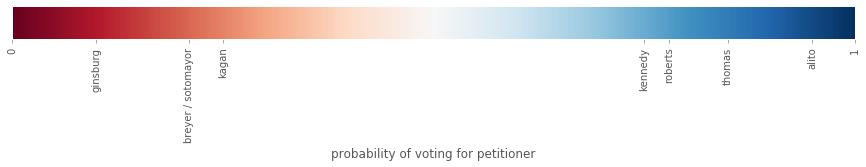

Predicted Outcome: Equally Divided Court


Pending



--------------------------------------------------------
Duncan v. Owens 
Ramon Nelson was riding his bike when he suffered a lethal blow to the back of his head with a baseball bat. After two eyewitnesses identified Lawrence Owens from an array of photos and then a lineup, he was tried and convicted for Nelson’s death. Because Nelson was carrying cocaine and crack cocaine potentially for distribution, the judge at Owens’ bench trial ruled that Owens was probably also a drug dealer and was trying to “knock [Nelson] off.” Owens was found guilty of first-degree murder and sentenced to 25 years in prison.

Owens filed a petition for a writ of habeas corpus on the grounds that his constitutional right to due process was violated during the trial. He argued that the eyewitness identification should have been inadmissible based on unreliability and that the judge impermissibly inferred a motive when a motive was not an element of the offe

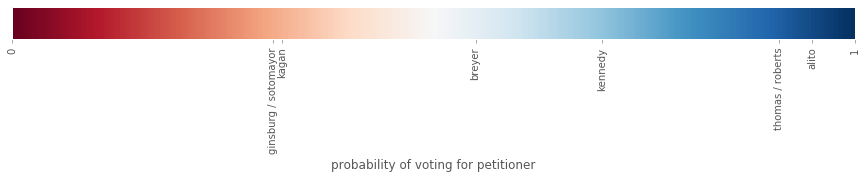

Predicted Outcome: 5-3 Win for Petitioner


Actual Outcome: dismissal - improvidently granted



--------------------------------------------------------
RJR Nabisco v. The European Community
The European Community and 26 of its member states sued RJR Nabisco (RJR) and alleged that RJR directed, managed, and controlled a global money-laundering enterprise in violation of the Racketeer Influenced and Corrupt Organizations (RICO) statute. The European Community claimed that Colombian and Russian criminal organizations imported illegal drugs into European countries, where they produced revenue in euros that was then laundered back into the currency of the criminal organizations’ home countries while the euros were sold to cigarette importers at a discounted rate to purchase RJR’s cigarettes. The lawsuit alleged that RJR controlled this operation and in the course of executing it committed various violations of the RICO statute as well as violations of New York state law. The defendants mo

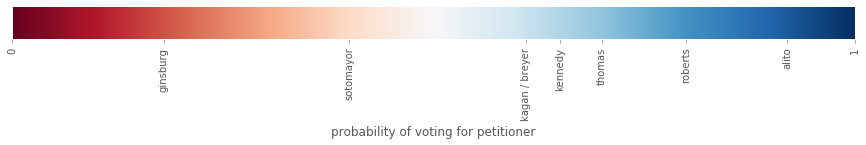

Predicted Outcome: 6-2 Win for Petitioner


Pending



--------------------------------------------------------
Molina-Martinez v. United States
Saul Molina-Martinez pleaded guilty to being in the United States illegally following deportation proceedings that stemmed from his felony convictions. The district court accordingly sentenced Molina-Martinez to 77 months in prison, pursuant to the sentencing range established in the U.S. Sentencing Guidelines for his criminal history category. Under the Sentencing Guidelines, prior sentences are counted as a single sentence if they were imposed on the same day unless the offenses in question were separated by an intervening arrest. Molina-Martinez’s prior offenses were not separated by an intervening arrest, so when his probation officer calculated his criminal history points and concluded that they placed him in category VI, he erred; Molina-Martinez should properly have been placed in category V, which carries a lower sentencing range of 70

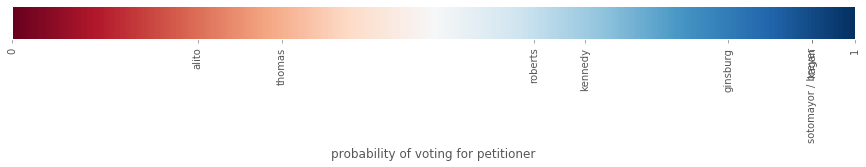

Predicted Outcome: 6-2 Win for Petitioner


Pending



--------------------------------------------------------
Taylor v. United States
David Anthony Taylor was a member of the “Southwest Goonz,” a group of robbers based in Roanoke, Virginia, that focused on robbing drug dealers, who typically have drug proceeds in their home and are reluctant to report crime. Taylor was indicted on two counts of robbery under the Hobbs Act, which prohibits actual or attempted robbery or extortion affecting interstate or foreign commerce. At Taylor’s second trial, after his first resulted in a hung jury, the government moved to prevent Taylor from offering evidence that robbing a drug dealer who grows marijuana outside of state lines does not affect interstate commerce and therefore cannot violate the Hobbs Act. The district court granted the government’s motion, and Taylor was subsequently convicted of both counts under the Hobbs Act. Taylor moved to set aside the verdict on the grounds that the gover

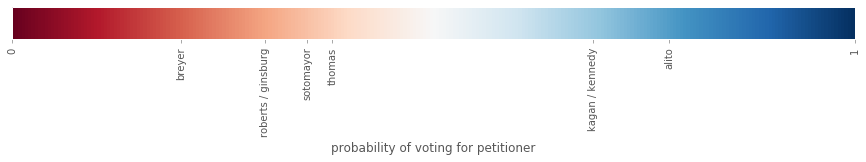

Predicted Outcome: 5-3 Win for Respondent


Pending



--------------------------------------------------------
Torres v. Lynch
In 1999, Jorge Luna Torres, a citizen of the Dominican Republic and a lawful permanent resident of the United States, was convicted of violating a New York state arson statute. In 2007, the Immigration and Naturalization Service (INS) issued a notice charging Torres with inadmissibility because he was an “alien convicted of a crime involving moral turpitude.” Torres applied for a cancellation of the removal order and the immigration judge held that Torres was both removable as charged and ineligible for a cancellation of the removal order because he was a permanent resident convicted of an aggravated felony; the Board of Immigration Appeals (BIA) had previously held that a conviction under the New York state arson statute constituted an aggravated felony. Torres appealed to the BIA and argued that the previous ruling should be reexamined. The BIA dismissed Tor

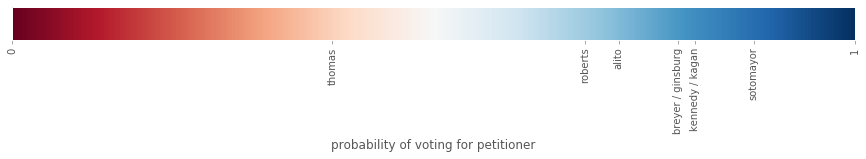

Predicted Outcome: 7-1 Win for Petitioner


Pending



--------------------------------------------------------
Merrill Lynch, Pierce, Fenner & Smith, Inc. v. Manning
The plaintiffs are shareholders in Escala Group, Inc. (Escala), and the defendants are a group of financial institutions that engage in equity trading. The plaintiffs sued the defendants in state court and alleged that the defendants participated in the short selling of Escala stock, which increased the pool of tradeable shares by electronically manufacturing counterfeit shares, thereby causing the plaintiffs’ shares to decline in value and dilute their voting rights. The plaintiffs’ claims were based on state law, but the Amended Complaint repeatedly mentioned a 2004 regulation that was adopted by the Securities and Exchange Commission (SEC) pursuant to the authority granted to it by the Securities Exchange Act of 1934, and no parties dispute the fact that the claims included violations of federal law. The defendants sou

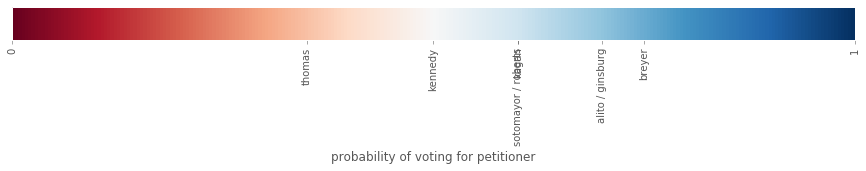

Predicted Outcome: 7-1 Win for Petitioner


Pending



--------------------------------------------------------
Menominee Indian Tribe of Wisconsin v. United States
Between 1995 and 2004, the Menominee Indian Tribe of Wisconsin (Menominee Tribe) provided healthcare services to members of the tribe pursuant to a self-determination contract with the Secretary of Health and Human Services (HHS). The self-determination contract states that the federal government will pay the participating tribe the amount that the government would have paid the Department of the Interior and HHS if those agencies were administering the program. The tribe and the government negotiate those costs in annual funding agreements.

In 2005, the Menominee Tribe filed administrative claims with the HHS’s Indian Health Service to recover contract support costs for the years 1995 through 2004. The claims were denied for the years 1996 through 1998 as untimely because the six-year statute of limitations had run. The M

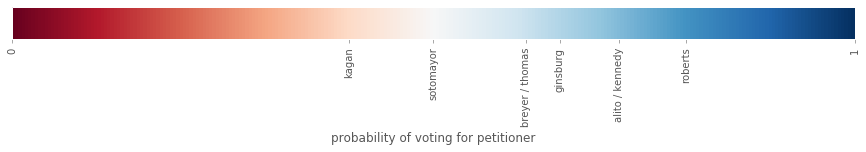

Predicted Outcome: 7-1 Win for Petitioner


Actual Outcome: 8-0 Win for Petitioner
Petitioner: kennedy, thomas, ginsburg, breyer, roberts, alito, sotomayor, kagan
Respondent: 



--------------------------------------------------------
Musacchio v. United States
Michael Musacchio was the president of Exel Transportation Services (ETS), a transportation brokerage company that arranges freight shipments for business clients, until his resignation in 2004. In 2005, Musacchio founded Total Transportation Services (TTS), a competing company, and several ETS agents moved to the new company with him. Around the same time, the new president of ETS became suspicious when potential new agents were unexpectedly familiar with the terms of ETS contracts. He discovered that Musacchio and other TTS agents had been accessing ETS servers, so ETS sued TTS and the parties settled for $10 million.

In 2010, the government indicted Musacchio and other TTS agents on counts of conspiracy and violations of th

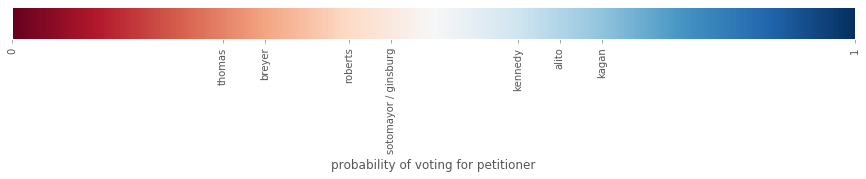

Predicted Outcome: 5-3 Win for Respondent


Actual Outcome: 8-0 Win for Petitioner
Petitioner: kennedy, thomas, ginsburg, breyer, roberts, alito, sotomayor, kagan
Respondent: 



--------------------------------------------------------
Kingdomware Technologies, Inc. v. United States
Various policies, regulations, and statutes of the federal government are intended to promote small businesses, especially those run by veterans. Although agencies generally have wide discretion to decide what method of contracting to use, a 2003 amendment to the Small Business Act established a goal of awarding three percent of government contracts to service-disabled veteran-owned small businesses, and the Veterans Act of 2006 expanded the reach of the relevant provisions.

Kingdomware Technologies is a small business owned and controlled by a service-disabled veteran and has been certified as such by the Department of Veteran Affairs (VA). In 2012, Kingdomware filed a bid for a project, but the VA awarde

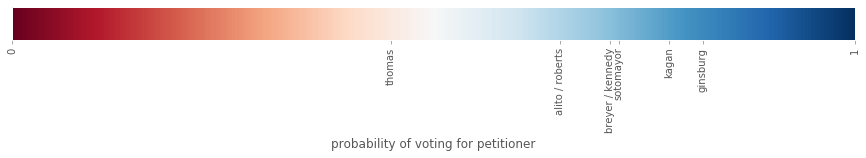

Predicted Outcome: 7-1 Win for Petitioner


Pending



--------------------------------------------------------
Lockhart v. United States
In June 2010, undercover federal agents conducted an operation in which Avondale Lockhart ordered a number of videos containing child pornography. When the agents ostensibly delivered the ordered videos, they executed a search warrant and discovered over 15,000 images and at least nine videos depicting child pornography on Lockhart’s computer. Lockhart was subsequently charged with possession of child pornography, and he pled guilty. Lockhart had previously been convicted in state court of first-degree sexual abuse due to an incident involving his adult girlfriend. Based on this previous conviction, the pre-sentencing report for Lockhart’s child pornography sentencing recommended that Lockhart be subject to a mandatory minimum sentence. Lockhart argued that the mandatory minimum did not apply to him because the previous sexual offense did not involve

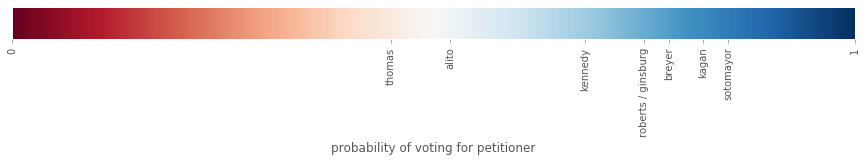

Predicted Outcome: 7-1 Win for Petitioner


Actual Outcome: 6-2 Win for Petitioner
Petitioner: kennedy, thomas, ginsburg, roberts, alito, sotomayor
Respondent: breyer, kagan



--------------------------------------------------------
Harris v. Arizona Independent Redistricting Commission
In 2012, the Arizona Independent Redistricting Commission redrew the map for the state legislative districts based on the results of the 2010 census. Wesley Harris and other individual voters sued the Commission and alleged that the newly redrawn districts were under-populated in Democratic-leaning districts and over-populated in Republican-leaning ones, and therefore that the Commission had violated the Equal Protection Clause of the Fourteenth Amendment. The Commission argued that the population deviations were the result of attempts to comply with the Voting Rights Act. The district court found in favor of the Commission and held that the redrawn districts represented a good faith effort to comply w

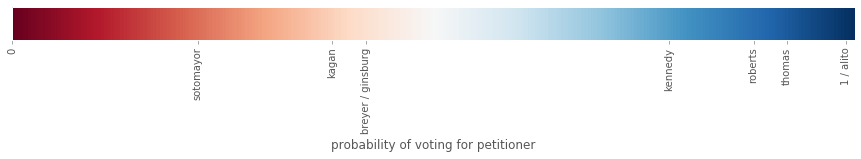

Predicted Outcome: Equally Divided Court


Pending



--------------------------------------------------------
Friedrichs v. California Teachers Association
California law allows unions to become the exclusive bargaining representative for the public school employees of that district and therefore have a great deal of influence over a wide range of conditions of employment. Once a union is the exclusive bargaining representative for the school district, it may establish an “agency shop” arrangement, which means that a school district may require a public school employee to either join the union or pay the equivalent of dues to the union in the form of a “fair share service fee.” Because the First Amendment prohibits unions from compelling nonmembers to support activities that are not exclusively devoted to negotiations, contract administration, and other duties as an exclusive bargaining representative, unions must send notices to all nonmembers laying out the breakdown of the chargeab

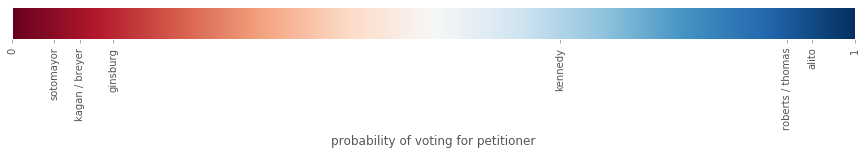

Predicted Outcome: Equally Divided Court


Actual Outcome: Equally Divided Court



--------------------------------------------------------
Gobeille v. Liberty Mutual Insurance Co.
Liberty Mutual Insurance Company (Liberty Mutual) operates a self-insured employee health plan through a third-party administrator. Vermont state law requires that all health plans, including self-insured plans, file reports containing claims data and other information with the state. The statute specifies what type of information is required and how it is transmitted. When Vermont subpoenaed claims data from the third-party administrator, Liberty Mutual sued the state and argued that the reporting requirements of the Employment Retirement Income Security Act of 1974 (ERISA) preempted the Vermont statute. The district court found in favor of the state and held that ERISA did not preempt the Vermont statute. The U.S. Court of Appeals for the Second Circuit reversed and held that ERISA preempted the state sta

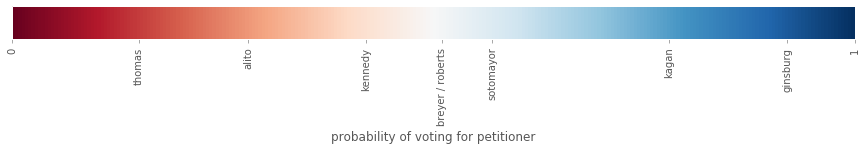

Predicted Outcome: 5-3 Win for Petitioner


Actual Outcome: 6-2 Win for Petitioner
Petitioner: kennedy, thomas, breyer, roberts, alito, kagan
Respondent: ginsburg, sotomayor



--------------------------------------------------------
Foster v. Chatman
In 1986, Timothy Tyrone Foster, an 18-year-old black man, was charged with murdering Queen White, an elderly white woman. At the trial, the prosecution used peremptory strikes against all four of the qualified black jurors. Pursuant to the Supreme Court’s decision in Batson v. Kentucky, which prohibits the use of peremptory strikes on the basis of race, the defense objected to those strikes, and the burden shifted to the prosecution to prove that there were race-neutral explanation for the strikes. The prosecution provided reasons, and the trial court held that the reasons were sufficient. An all-white jury convicted Foster of murder and imposed the death penalty.

Foster filed a motion for post-judgment discovery regarding the prosecutio

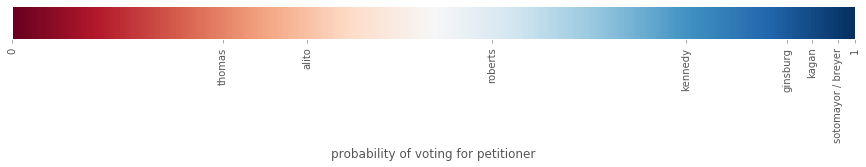

Predicted Outcome: 6-2 Win for Petitioner


Pending



--------------------------------------------------------
Fisher v. University of Texas
Abigail Fisher, a white female, applied for admission to the University of Texas but was denied. She did not qualify for Texas' Top Ten Percent Plan, which guarantees admission to the top ten percent of every in-state graduating high school class. For the remaining spots, the university considers many factors, including race. Fisher sued the University and argued that the use of race as a consideration in the admissions process violated the Equal Protection Clause of the Fourteenth Amendment. The district court held that the University’s admissions process was constitutional, and the U.S. Court of Appeals for the Fifth Circuit affirmed. The case went to the Supreme Court, which held that the appellate court erred by not applying the strict scrutiny standard to the University’s admission policies. The case was remanded, and the appellate court rea

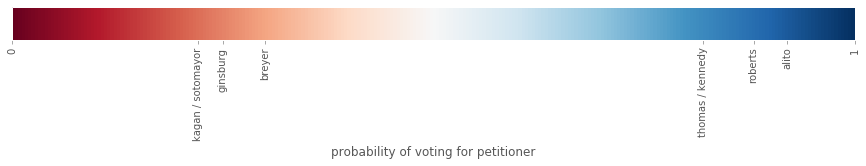

Predicted Outcome: Equally Divided Court


Pending



--------------------------------------------------------
Federal Energy Regulatory Commission v. Electric Power Supply Association, et al.
The Federal Power Act (FPA) grants the Federal Energy Regulatory Commission (FERC) the authority to regulate the wholesale interstate transmission and sale of electric power. In 2011, FERC promulgated a rule that established uniform compensation levels for suppliers of demand-side resources that meet certain conditions, including cost-effectiveness as measured by a net benefits test. The rule’s stated purpose was to incentivize retail customers to reduce electricity consumption when it was economically efficient to do so. Various state regulatory agencies, trade associations, publicly owned utilities, transmission owners, and other industry groups requested a rehearing on the rule and argued that it conflicted with FERC’s efforts to promote a competitive market as well as FERC’s statutory mandate

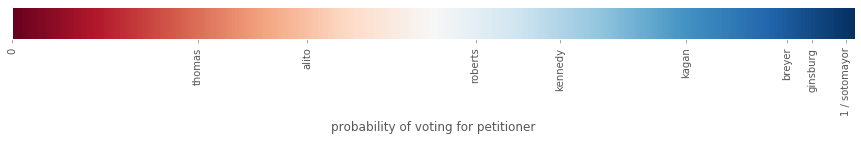

Predicted Outcome: 6-2 Win for Petitioner


Actual Outcome: 6-1 Win for Petitioner
Petitioner: kennedy, ginsburg, breyer, roberts, sotomayor, kagan
Respondent: thomas



--------------------------------------------------------
Bruce v. Samuels
Several prisoners housed in the Special Management Unit (SMU) of the Federal Correctional Institution in Talladega, which is for gang-affiliated and other disruptive inmates, sued Bureau of Prisons (BOP) officials and claimed that SMUs violated the Eighth Amendment. Because SMUs housed gang-affiliated prisoners, the petitioners argued that the SMUs were unconstitutionally violent and dangerous because the BOP officials did not separate members of rival gangs. The prisoners moved to proceed in forma pauperis, which would allow them to waive filing fees. The parties then engaged in extensive back-and-forth filings regarding the collection of filing fees and the ability of other prisoners to join in the case. The U.S. Court of Appeals for the Distri

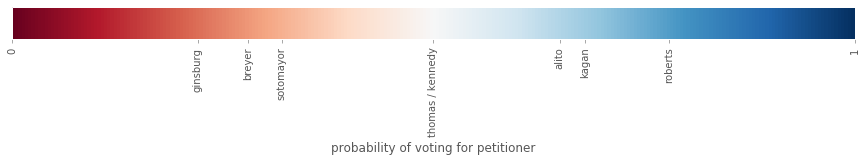

Predicted Outcome: 5-3 Win for Petitioner


Actual Outcome: 8-0 Win for Petitioner
Petitioner: kennedy, thomas, ginsburg, breyer, roberts, alito, sotomayor, kagan
Respondent: 



--------------------------------------------------------
Dollar General Corporation v. Mississippi Band of Choctaw Indians
Dollar General Corporation (Dollar General) operates a store on land held in trust for the Mississippi Band of Choctaw Indians (Tribe). The store operates pursuant to a lease and business license agreement with the Tribe. In the spring of 2003, John Doe, a 13-year-old member of the Tribe alleged that he was sexually molested by the store manager, Dale Townsend, while he was working at the store as part of an internship program that the Tribe runs and in which the Townsend agreed to participate.

In 2005, Doe sued Townsend and Dollar General in tribal court. Both defendants moved to dismiss the case for lack of subject matter jurisdiction, and the tribal court denied the motions. The Chocta

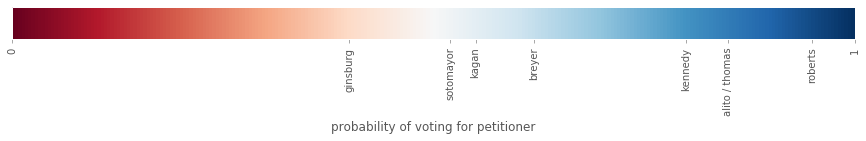

Predicted Outcome: 7-1 Win for Petitioner


Pending



--------------------------------------------------------
Shapiro v. McManus
In 2011, the Maryland General Assembly enacted a redistricting plan based on the results of the 2010 census. Several of the districts consisted of de-facto non-contiguous segments—discrete segments that would be wholly unconnected but for one or two narrow strips connecting the two—often with largely inconsistent demographics between the two large segments. The plaintiffs were a group of citizens who sued the Chair of the Maryland State Board of Elections (Board) and the State Administrator of the Board and argued that the new districting plan violated their rights to political association and equal representation under the First and Fourteenth Amendments. The defendants moved to dismiss the suit under Federal Rule of Civil Procedure 12(b)(6), which requires that a complaint be plausible on its face and enable the court to draw a reasonable inference of mis

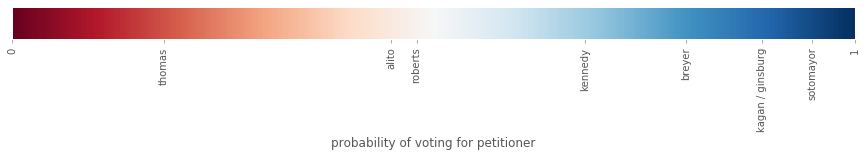

Predicted Outcome: 5-3 Win for Petitioner


Actual Outcome: 8-0 Win for Petitioner
Petitioner: kennedy, thomas, ginsburg, breyer, roberts, alito, sotomayor, kagan
Respondent: 



--------------------------------------------------------
Luis v. United States
A federal grand jury indicted Sila Luis for her alleged role in a Medicare fraud scheme that involved giving kickbacks to patients who enrolled with her home healthcare companies. Because federal law allows the government to file a pretrial motion to restrain the assets of defendants accused of particular types of fraud, including substitute assets not directly related to the fraud, the government did so in this case. Luis objected to the motion and argued that she needed those funds in order to pay for her criminal defense lawyer, and therefore granting the motion would violate her right to counsel under the Sixth Amendment. The district court granted the motion, and the U.S. Court of Appeals for the Eleventh Circuit affirmed.


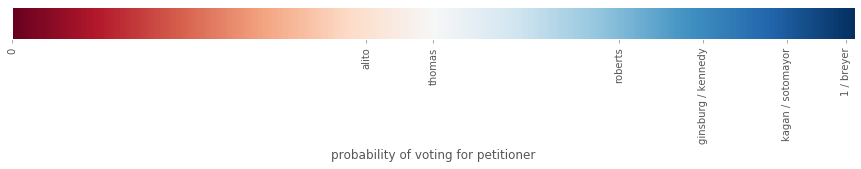

Predicted Outcome: 7-1 Win for Petitioner


Actual Outcome: plurality opinion



--------------------------------------------------------
Evenwel v. Abbott
The Texas Constitution requires that the state legislature reapportion its senate districts during the first regular session after every federal census. After the 2010 census, the legislature created a redistricting plan that was signed into law. However, a three-judge panel of the federal district court found that there was a substantial claim that this redistricting plan violated the Voting Rights Act and issued an interim plan for the 2012 primary elections that was subsequently adopted and signed into law.

Plaintiffs Sue Evenwel and Edward Pfenniger are registered Texas voters who sued and claimed that the interim plan that was adopted and signed into law violated the Equal Protection Clause of the Fourteenth Amendment. They argued that the new districts do not adhere to the 'one person, one vote' principle, which the Supreme C

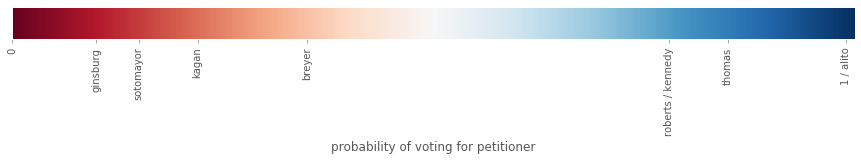

Predicted Outcome: Equally Divided Court


Actual Outcome: 8-0 Win for Petitioner
Petitioner: kennedy, thomas, ginsburg, breyer, roberts, alito, sotomayor, kagan
Respondent: 



--------------------------------------------------------
Campbell-Ewald Company v. Gomez
On May 11, 2006, Jose Gomez received an unsolicited text message advertising the U.S. Navy. The text message was the result of a partnership between the Navy and the Campbell-Ewald Company, a marketing consultant that the Navy hired to help with a recruiting campaign. The compilation of the list of targeted phone numbers and the actual sending of the message was outsourced to a company called Mindmatics.

Gomez sued and argued that that Campbell-Ewald violated the Telephone Consumer Protection Act by instructing or allowing a third-party vendor to send unsolicited text messages on the behalf of a client. After Campbell-Ewald’s motion to dismiss was denied, the company offered Gomez a settlement, which Gomez rejected. Campbe

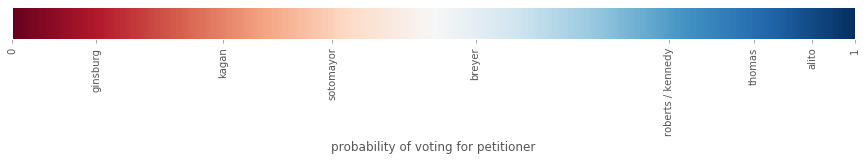

Predicted Outcome: 5-3 Win for Petitioner


Actual Outcome: 6-2 Win for Petitioner
Petitioner: kennedy, thomas, ginsburg, breyer, sotomayor, kagan
Respondent: roberts, alito



--------------------------------------------------------
Green v. Brennan
Marvin Green began working for the United States Postal Service in 1973. In 2002, he became the postmaster at the Englewood, Colorado, post office. In 2008, a postmaster position opened in Boulder, and Green applied but did not receive the position. He filed a formal Equal Employment Opportunity (EEO) charge regarding the denial of his application, and the charge was settled. In 2009, Green filed an informal EEO charge and alleged that his supervisor and supervisor’s replacement had been retaliating against him for his prior EEO activity. Throughout that year, Green was subject to internal Postal Service investigations including a threat of criminal prosecution. He ultimately signed an agreement that he would immediately give up his positi

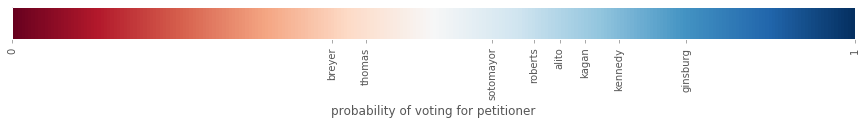

Predicted Outcome: 6-2 Win for Petitioner


Pending



--------------------------------------------------------
Spokeo, Inc. v. Robins
Spokeo, Inc. (Spokeo) operated a website that provided information about individuals such as contact data, marital status, age, occupation, and certain types of economic information. Thomas Robins sued Spokeo and claimed that the company willfully violated the Fair Credit Reporting Act (FCRA) by publishing false information about him on the website. However, Robins was unable to allege any “actual or imminent harm,” so the district court granted Spokeo’s motion to dismiss for lack of subject-matter jurisdiction and Robins’ lack of standing under Article III of the Constitution. Robins then filed an amended complaint in which he alleged that he suffered actual harm to his employment prospects due to the website falsely claiming that he was wealthy. The district court originally denied Spokeo’s motion to dismiss but later reconsidered its order and dismis

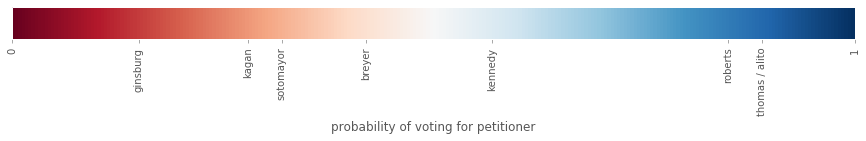

Predicted Outcome: Equally Divided Court


Pending



--------------------------------------------------------
Montanile v. Board of Trustees of the National Elevator Industrial Health Benefit Plan
In late 2008, Robert Montanile was involved in a car accident that resulted in significant injuries. Montanile was covered by an employee welfare benefit plan administered by the Board of Trustees of the National Elevator Industrial Health Benefit Plan (Plan). After Montanile’s accident, the Plan dispersed over $120,000 to cover Montanile’s medical expenses. Montanile later sued the driver of the other car involved in the accident, eventually obtaining a $500,000 settlement. Per its terms, the Plan then requested that Montanile reimburse the initial $120,000 disbursement. When Montanile and the Plan were unable to reach an agreement, the Plan sued Montanile.

The Plan is governed by the Employee Retirement Income Security Act of 1974 (ERISA), which allows plan administrators to recover overp

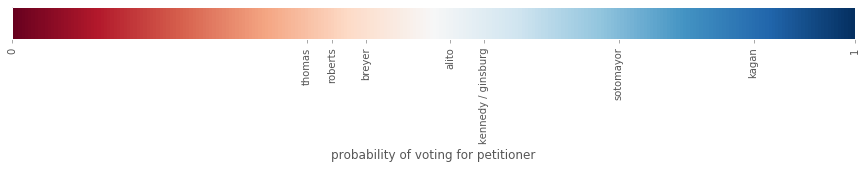

Predicted Outcome: 5-3 Win for Petitioner


Actual Outcome: 7-1 Win for Petitioner
Petitioner: kennedy, thomas, breyer, roberts, alito, sotomayor, kagan
Respondent: ginsburg



--------------------------------------------------------
DIRECTV, Inc. v. Imburgia
On September 7, 2008, Amy Imburgia filed a class action lawsuit against DIRECTV, Inc. (DIRECTV), and argued that DIRECTV had improperly charged early termination fees to its customers. In 2011, the U.S. Supreme Court decided AT&amp;T Mobility LLC v. Concepcion, in which the Court held that the Federal Arbitration Act preempted California precedent that had previously held that, in certain circumstances, arbitration clauses in customer agreements were unenforceable. Less than one month after that decision, DIRECTV moved to stay or dismiss the plaintiffs’ case and compel arbitration, which DIRECTV argued it had not done previously because it thought the arbitration clause in its customer agreement was void under California precedent

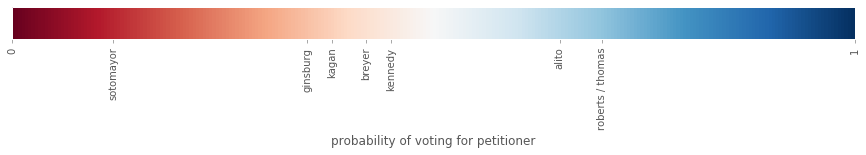

Predicted Outcome: 5-3 Win for Respondent


Actual Outcome: 5-3 Win for Petitioner
Petitioner: kennedy, breyer, roberts, alito, kagan
Respondent: thomas, ginsburg, sotomayor



--------------------------------------------------------
Montgomery v. Louisiana
In 1963, Henry Montgomery was found guilty and received the death penalty for the murder of Charles Hunt, which Montgomery committed less than two weeks after he turned 17. He appealed to the Louisiana Supreme Court, and his conviction was overturned because of community prejudice. At his new trial, Montgomery was again convicted, but he was sentenced to life without parole.

In 2012, the U.S. Supreme Court decided Miller v. Alabama, in which the Court held that mandatory sentencing schemes requiring children convicted of homicide to be sentenced to life imprisonment without parole violate the Eighth Amendment. In light of that decision, Montgomery filed a motion in state district court to correct what he argued was now an illegal s

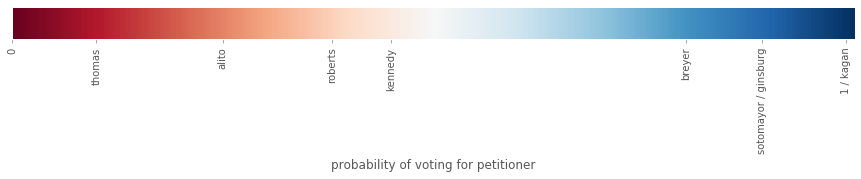

Predicted Outcome: Equally Divided Court


Actual Outcome: 6-2 Win for Petitioner
Petitioner: kennedy, ginsburg, breyer, roberts, sotomayor, kagan
Respondent: thomas, alito



--------------------------------------------------------
Hurst v. Florida
Timothy Lee Hurst was charged and convicted of first-degree murder for killing his co-worker, Cynthia Harrison, during a robbery of the Popeye’s restaurant where they both worked. He was sentenced to death and appealed. On appeal, Hurst was granted a new sentencing trial because the Supreme Court of Florida found that his counsel should have investigated and presented evidence of Hurst’s borderline intelligence and possible organic brain damage. At his new sentencing trial, Hurst was prevented from presenting mental retardation evidence as an absolute bar to the imposition of the death penalty, though he was allowed to present it as mitigating evidence. The jury again sentenced Hurst to the death penalty by a vote of seven to five, and the 

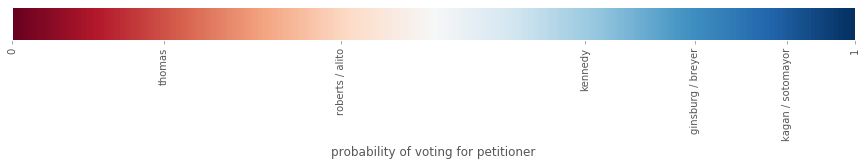

Predicted Outcome: 5-3 Win for Petitioner


Actual Outcome: 7-1 Win for Petitioner
Petitioner: kennedy, thomas, ginsburg, breyer, roberts, sotomayor, kagan
Respondent: alito



DECIDED: 23
CORRECT: 14
INCORRECT: 9
PENDING: 34


In [994]:
import matplotlib as mpl
top = True
count_decided = 0
count_pending = 0
count_correct = 0
count_incorrect = 0
for k in range(0, len(current_term)):
    if top:
        top = False
    else:
        print '--------------------------------------------------------'
    raw_probs = np.array(predictions[k])
    probabilities = np.round(np.array(predictions[k].tolist() + [0, 1]), 2)
    names = np.array(j_names + [0, 1])
    order = np.argsort(probabilities)
    names = names[order].tolist()
    probabilities = probabilities[order]
    probabilities = probabilities.tolist()
    print current_term.iloc[k]['name']
    print current_term.iloc[k]['facts'].replace('\n','\n\n')
    in_range = False
    i = 0
    while i < len(probabilities)-1:
        if np.abs(probabilities[i] - probabilities[i+1])<.025:
            p = probabilities.pop(i)
            probabilities[i] = (probabilities[i]+ p)/2.0
            n = names.pop(i)
            names[i] = names[i]  + ' / ' + n 
        i += 1
            
    fig = plt.figure(figsize=(13,3))
    ax1 = fig.add_axes([.05, .8, .9, 0.15])
    
    cbar = mpl.colorbar.ColorbarBase(ax1, cmap='RdBu', 
                                     norm=mpl.colors.Normalize(vmin=0, vmax=1), 
                                     orientation='horizontal')
    cbar.set_label('probability of voting for petitioner')
    top_ticks = probabilities
    top_names = names
    cbar.set_ticks(probabilities)
    cbar.ax.set_xticklabels(names, rotation=90)
    plt.show()    
    petitioner_votes = np.count_nonzero(np.array(raw_probs)>=.5)
    respondent_votes = np.count_nonzero(np.array(raw_probs)<.5)
    outcome_code = 'o'
    if petitioner_votes>4:
        outcome="{}-{} Win for Petitioner".format(petitioner_votes, 
                                                  respondent_votes)
        outcome_code = 'p'
    elif petitioner_votes==4:
        outcome="Equally Divided Court"
        outcome_code = 'e'
    else:
        outcome="{}-{} Win for Respondent".format(respondent_votes, 
                                                  petitioner_votes)
        outcome_code = 'r'
    print 'Predicted Outcome: {}'.format(outcome)
    print '\n'
    if current_term.iloc[k]['date_decided']:
        count_decided += 1
        if current_term.iloc[k]['decision_type'] not in ['majority opinion', 
                                                         'equally divided']:
            print 'Actual Outcome: ' + current_term.iloc[k]['decision_type'] 
            a_outcome = 'o'
        elif current_term.iloc[k]['decision_type'] == 'equally divided':
            a_outcome = 'e'
            print 'Actual Outcome: ' + "Equally Divided Court"
        else:
            votes = current_term.iloc[k][['vote_side_'+name for name in j_names]].values
            petitioner_votes = np.count_nonzero(np.array(votes)<0)
            respondent_votes = np.count_nonzero(np.array(votes)>0)
            if petitioner_votes>4:
                print 'Actual Outcome: ' + "{}-{} Win for Petitioner".format(petitioner_votes, 
                                                          respondent_votes)
                a_outcome = 'p'
                print "Petitioner: " + ", ".join(np.array(j_names)[np.array(votes)<0])
                print "Respondent: " + ", ".join(np.array(j_names)[np.array(votes)>0])
            else:
                print 'Actual Outcome: ' +"{}-{} Win for Respondent".format(respondent_votes, 
                                                          petitioner_votes)
                a_outcome = 'r'
                print "Petitioner: " + ", ".join(np.array(j_names)[np.array(votes)<0])
                print "Respondent: " + ", ".join(np.array(j_names)[np.array(votes)>0])
        if a_outcome == outcome_code:
            count_correct += 1
        else:
            count_incorrect += 1
    else:
        count_pending += 1
        print "Pending"
    print '\n\n'
    
print 'DECIDED: {}\nCORRECT: {}\nINCORRECT: {}\nPENDING: {}'.format(count_decided,
                                                                    count_correct,
                                                                    count_incorrect,
                                                                    count_pending)